# Visualize CMIP6 model trend variability data

__Figure 1: TTE Money Obs Figure__  

(a) Show regional time-to-emergence without observational uncertainty  

(b) Middle panel is the delay due to observational uncertainty  

(c) Right panel is the “true” time-to-emergence.

## Code

In [1]:
import sys,warnings
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/internalvar-vs-obsunc/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/internalvar-vs-obsunc/Common/')

from imports import (
    np, xr, plt, sns, os,
    glob, dask
    )

%matplotlib inline

### Load processed trend data

#### Models

In [2]:
# I need to go from the CAM output variables to the CMOR/CMIP standard names.
pic_tseries_dir = '/glade/work/jonahshaw/trend_uncertainty/nathan/CMIP6_PIC/'
cesm1_dir       = 'CESM1/'
mpi_dir         = 'MPI-GE/'
canesm2_dir     = 'CanESM2/'
esm2m_dir       = 'ESM2M/'

cesm1_cmor_var_dict = {'ts':'TS','tas':'TREFHT','psl':'PSL'}

In [3]:
cesm1_trends_filepath   = glob.glob('%s/%s/*5x5degSpatialTrends.Percentiles*.nc' % (pic_tseries_dir,cesm1_dir))
mpi_trends_filepath     = glob.glob('%s/%s/*5x5degSpatialTrends.Percentiles*.nc' % (pic_tseries_dir,mpi_dir))
canesm2_trends_filepath = glob.glob('%s/%s/*5x5degSpatialTrends.Percentiles*.nc' % (pic_tseries_dir,canesm2_dir))
esm2m_trends_filepath   = glob.glob('%s/%s/*5x5degSpatialTrends.Percentiles*.nc' % (pic_tseries_dir,esm2m_dir))

Load the trend data.

In [4]:
cesm1_pic_trends_all   = xr.open_dataarray(*cesm1_trends_filepath)

mpi_pic_trends_all     = xr.open_dataarray(*mpi_trends_filepath)

canesm2_pic_trends_all = xr.open_dataarray(*canesm2_trends_filepath)

esm2m_pic_trends_all   = xr.open_dataarray(*esm2m_trends_filepath)

#### Observations

In [5]:
obs_tseries_dir = '/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/'
gistemp_5x5_dir = 'GISTEMP_5x5/'
hadcrut5_dir    = 'HadCRUT5/'

In [6]:
gistemp_tas_var = 'tempAnom'
hadcrut5_tas_var = 'tas'

In [7]:
gistemp_5x5_trends_filepath  = glob.glob('%s/%s/*.Percentiles*.nc' % (obs_tseries_dir,gistemp_5x5_dir))
hadcrut5_trends_filepath     = glob.glob('%s/%s/*.Percentiles*.nc' % (obs_tseries_dir,hadcrut5_dir))

Load the trend data

In [8]:
gistemp_5x5_trends_all  = xr.open_dataarray(*gistemp_5x5_trends_filepath)
hadcrut5_trends_all     = xr.open_dataarray(*hadcrut5_trends_filepath).rename({'latitude':'lat','longitude':'lon'})

### Define functions

???

### Plot ideas!

Normalize according to the Weatherhead math to evaluate the AR1 assumption.

In [9]:
import regionmask

import cartopy.crs as ccrs
import matplotlib.patheffects as pe

from functions import sp_map

from functions import to_png

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The plot with the observational uncertainty has less meaning, because the temporal change in trend uncertainty is not as consistent as with the models. (i.e. 10-year uncertainty isn’t a good proxy for the rest of the observational record). In general, the observational uncertainty resembles the internal variability, but is about half the magnitude.

## Compute time-to-emergence and observational delay

### Compute TTE generally

I should be able to classify the delays in regions which haven't "truly" emerged using inequalities. i.e. obs-delay > 10 years

__GISTEMP__

In [10]:
# If the duration with the last "False" is 3, then we needed to observe for 4 years for the signal to emerge. 
# Then the signal emerged at the end of the fourth year 1963 or the beginning of the 5th year (1964).
# So I add 1960 to the duration of the last "False" and we report the year when the signal emerged. i.e. If we had stopped measuring then it would be emerged.

mean_tte_bool         = gistemp_5x5_trends_all.sel(percentile=50.0) > cesm1_pic_trends_all.sel(percentile=97.5)
mean_tte_gistemp      = 1960 + mean_tte_bool.duration.where(~mean_tte_bool).max(dim='duration')
mean_tte_gistemp      = mean_tte_gistemp.where(mean_tte_gistemp!=(1960+gistemp_5x5_trends_all.duration.max()),np.nan) # Mask the unemerged regions

true_tte_bool         = gistemp_5x5_trends_all.sel(percentile=2.5) > cesm1_pic_trends_all.sel(percentile=97.5)
true_tte_gistemp      = 1960 + true_tte_bool.duration.where(~true_tte_bool).max(dim='duration')
true_tte_gistemp      = true_tte_gistemp.where(true_tte_gistemp!=(1960+gistemp_5x5_trends_all.duration.max()),np.nan) # Mask the unemerged regions

In [11]:
simple_delay_gistemp = true_tte_gistemp -  mean_tte_gistemp

# Hasn't emerged in the mean sense.
fully_undef_gistemp = np.isnan(mean_tte_gistemp)

# Emerged in the mean sense but not the "true" sense.
part_undef_gistemp  = np.bitwise_and(np.isnan(true_tte_gistemp), ~np.isnan(mean_tte_gistemp))

# The conditonal delay is a lower bound, because the true signal has yet to emerge.
delay_conditional_gistemp = xr.where(part_undef_gistemp,2020 - mean_tte_gistemp,np.nan)

combined_delay_gistemp = xr.where(part_undef_gistemp,delay_conditional_gistemp,xr.where(~fully_undef_gistemp,simple_delay_gistemp,np.nan))
# combined_delay1 = xr.where(~fully_undef,simple_delay,np.nan)
# combined_delay2 = xr.where(part_undef,delay_conditional,combined_delay1)

__HadCRUT5__

In [12]:
# If the duration with the last "False" is 3, then we needed to observe for 4 years for the signal to emerge. 
# Then the signal emerged at the end of the fourth year 1963 or the beginning of the 5th year (1964).
# So I add 1960 to the duration of the last "False" and we report the year when the signal emerged. i.e. If we had stopped measuring then it would be emerged.

mean_tte_bool    = hadcrut5_trends_all.sel(percentile=50.0) > cesm1_pic_trends_all.sel(percentile=97.5)
mean_tte_hadcrut = 1960 + mean_tte_bool.duration.where(~mean_tte_bool).max(dim='duration')
mean_tte_hadcrut = mean_tte_hadcrut.where(mean_tte_hadcrut!=(1960+hadcrut5_trends_all.duration.max()),np.nan) # Mask the unemerged regions

true_tte_bool    = hadcrut5_trends_all.sel(percentile=2.5) > cesm1_pic_trends_all.sel(percentile=97.5)
true_tte_hadcrut = 1960 + true_tte_bool.duration.where(~true_tte_bool).max(dim='duration')
true_tte_hadcrut = true_tte_hadcrut.where(true_tte_hadcrut!=(1960+hadcrut5_trends_all.duration.max()),np.nan) # Mask the unemerged regions

In [13]:
simple_delay_hadcrut = true_tte_hadcrut -  mean_tte_hadcrut

# Hasn't emerged in the mean sense.
fully_undef_hadcrut = np.isnan(mean_tte_hadcrut)

# Emerged in the mean sense but not the "true" sense.
part_undef_hadcrut  = np.bitwise_and(np.isnan(true_tte_hadcrut), ~np.isnan(mean_tte_hadcrut))

# The conditonal delay is a lower bound, because the true signal has yet to emerge.
delay_conditional_hadcrut = xr.where(part_undef_hadcrut,2020 - mean_tte_hadcrut,np.nan)

combined_delay_hadcrut = xr.where(part_undef_hadcrut,delay_conditional_hadcrut,xr.where(~fully_undef_hadcrut,simple_delay_hadcrut,np.nan))
# combined_delay1 = xr.where(~fully_undef,simple_delay,np.nan)
# combined_delay2 = xr.where(part_undef,delay_conditional,combined_delay1)

Compute the observational delay and a mask where the delay is not known.

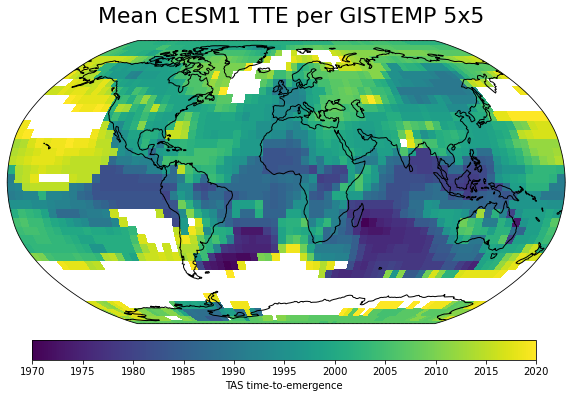

In [14]:
model_name = 'Mean CESM1 TTE per GISTEMP 5x5'
data = mean_tte_gistemp

fig = plt.figure(figsize=(10,7))

ax = plt.axes(projection=ccrs.Robinson(),)

cax = plt.axes([0.16, 0.15, 0.7, 0.04])

# im = ax.contourf(data.lon,data.lat,data, 60,
#                  transform=ccrs.PlateCarree(),levels=np.linspace(1960,2020,13))

im = ax.pcolormesh(data.lon,data.lat,data,transform=ccrs.PlateCarree())

ax.coastlines()
ax.set_global()

fig.colorbar(im,orientation='horizontal',
             ticks=np.linspace(1960,2020,13),
             label='TAS time-to-emergence',
             cax=cax
            )
fig.suptitle(model_name,fontsize=22,x=0.52,y=0.85)

plt.show()

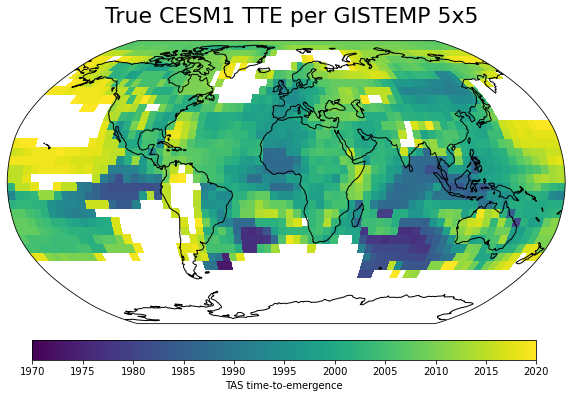

In [15]:
model_name = 'True CESM1 TTE per GISTEMP 5x5'
data = true_tte_gistemp

fig = plt.figure(figsize=(10,7))

ax = plt.axes(projection=ccrs.Robinson(),)

cax = plt.axes([0.16, 0.15, 0.7, 0.04])

# im = ax.contourf(data.lon,data.lat,data, 60,
             # transform=ccrs.PlateCarree(),levels=np.linspace(1960,2020,13))

im = ax.pcolormesh(data.lon,data.lat,data,transform=ccrs.PlateCarree(),vmin=1970)

ax.coastlines()
ax.set_global()

fig.colorbar(im,orientation='horizontal',
             ticks=np.linspace(1960,2020,13),
             label='TAS time-to-emergence',
             cax=cax
            )
fig.suptitle(model_name,fontsize=22,x=0.52,y=0.85)

plt.show()

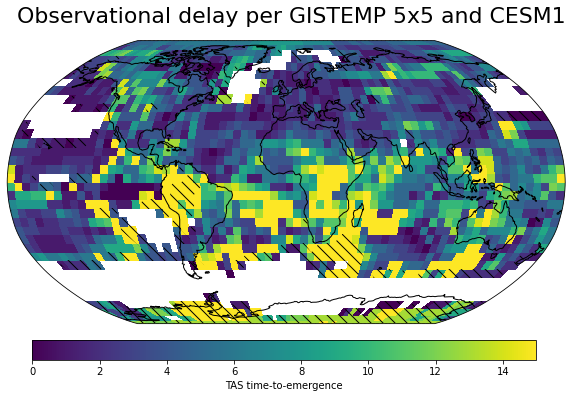

In [18]:
model_name = 'Observational delay per GISTEMP 5x5 and CESM1'
data = combined_delay_gistemp
data_undef = part_undef_gistemp

fig = plt.figure(figsize=(10,7))

ax = plt.axes(projection=ccrs.Robinson(),)

cax = plt.axes([0.16, 0.15, 0.7, 0.04])

im = ax.pcolormesh(data.lon,data.lat,data,transform=ccrs.PlateCarree(),
                   vmin=0,vmax=15)#,extend='max')

im2 = ax.contourf(part_undef_gistemp.lon,part_undef_gistemp.lat,part_undef_gistemp,colors='none',alpha=0,
                  levels=[-1,0.5,2],
                  transform=ccrs.PlateCarree(),hatches=[None,'\\\\'],extend='neither')

ax.coastlines()
ax.set_global()

fig.colorbar(im,orientation='horizontal',
             ticks=np.linspace(0,14,8),
             label='TAS time-to-emergence',
             cax=cax
            )
fig.suptitle(model_name,fontsize=22,x=0.52,y=0.85)

plt.show()

Hatching indicates that the delay is a lower bound because the trend hasn't actually emerged.

#### Combined plots

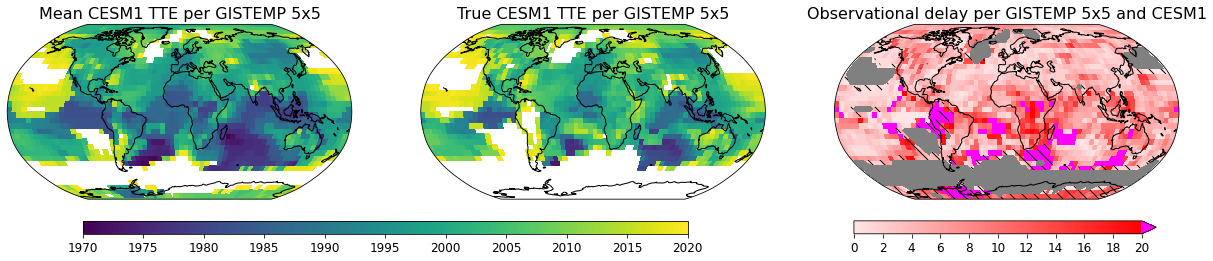

In [19]:
fig,axs = sp_map(1,3,projection=ccrs.Robinson(),figsize=(21,6))
axs = axs.flat

cax1 = plt.axes([0.175, 0.22, 0.40, 0.03])
cax2 = plt.axes([0.685, 0.22, 0.20, 0.03])

delay_cmap = sns.light_palette('red',n_colors=10,reverse=False,as_cmap=True)
delay_cmap.set_over('magenta')
delay_mask = combined_delay_gistemp

model_name = 'Mean CESM1 TTE per GISTEMP 5x5'
data = mean_tte_gistemp
part_undef_mask = part_undef_gistemp
full_undef_mask = fully_undef_gistemp
# Panel 1
ax = axs[0]

im0 = ax.pcolormesh(data.lon,data.lat,data,transform=ccrs.PlateCarree(),vmin=1970,vmax=2020)

ax.coastlines()
ax.set_global()

ax.set_title(model_name,fontsize=16)#,x=0.52,y=1)

# Panel 2
ax = axs[1]

model_name = 'True CESM1 TTE per GISTEMP 5x5'
data = true_tte_gistemp

im1 = ax.pcolormesh(data.lon,data.lat,data,transform=ccrs.PlateCarree(),vmin=1970,vmax=2020)

ax.coastlines()
ax.set_global()

ax.set_title(model_name,fontsize=16)

# Panel 3
model_name = 'Observational delay per GISTEMP 5x5 and CESM1'
data = combined_delay_gistemp

ax = axs[2]

im2 = ax.pcolormesh(data.lon,data.lat,data,transform=ccrs.PlateCarree(),
                   vmin=0,vmax=20,cmap=delay_cmap)#,extend='max')

im3 = ax.contourf(part_undef_mask.lon,part_undef_mask.lat,part_undef_mask,colors='none',alpha=0,
                  levels=[-1,0.5,2],
                  transform=ccrs.PlateCarree(),hatches=[None,'\\\\'],extend='neither')

grey = ax.contourf(full_undef_mask.lon,full_undef_mask.lat,full_undef_mask,
                   transform=ccrs.PlateCarree(),
                   extend='max',colors=['none','gray'],levels=[0,0.5,1.5],
                  )

ax.coastlines()
ax.set_global()
ax.set_title(model_name,fontsize=16)


cbar1 = fig.colorbar(im0,orientation='horizontal',
                     ticks=np.linspace(1960,2020,13),
                     cax=cax1,extend="neither"
                    )

cbar2 = fig.colorbar(im2,orientation='horizontal',
                     ticks=np.linspace(0,20,11), # delay_levels, 
                     cax=cax2,extend="max"
                    )

cbar1.ax.tick_params(labelsize=12) 
cbar2.ax.tick_params(labelsize=12) 

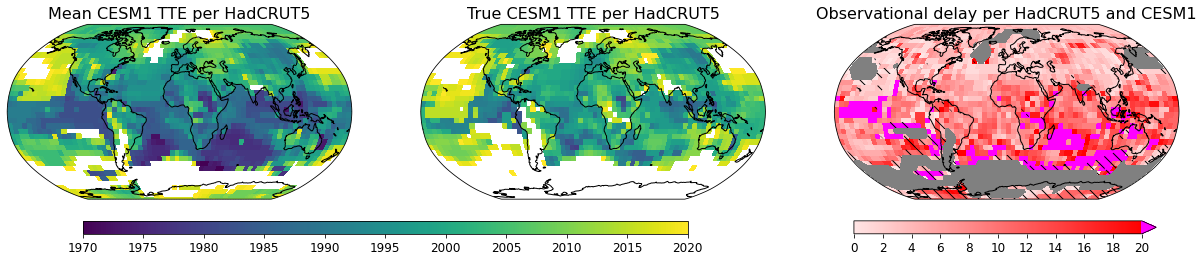

In [20]:
fig,axs = sp_map(1,3,projection=ccrs.Robinson(),figsize=(21,6))
axs = axs.flat

cax1 = plt.axes([0.175, 0.22, 0.40, 0.03])
cax2 = plt.axes([0.685, 0.22, 0.20, 0.03])

delay_cmap = sns.light_palette('red',n_colors=10,reverse=False,as_cmap=True)
delay_cmap.set_over('magenta')
delay_mask = combined_delay_hadcrut

model_name = 'Mean CESM1 TTE per HadCRUT5'
data = mean_tte_hadcrut
part_undef_mask = part_undef_hadcrut
full_undef_mask = fully_undef_hadcrut
# Panel 1
ax = axs[0]

im0 = ax.pcolormesh(data.lon,data.lat,data,transform=ccrs.PlateCarree(),vmin=1970,vmax=2020)

ax.coastlines()
ax.set_global()

ax.set_title(model_name,fontsize=16)#,x=0.52,y=1)

# Panel 2
ax = axs[1]

model_name = 'True CESM1 TTE per HadCRUT5'
data = true_tte_hadcrut

im1 = ax.pcolormesh(data.lon,data.lat,data,transform=ccrs.PlateCarree(),vmin=1970,vmax=2020)

ax.coastlines()
ax.set_global()

ax.set_title(model_name,fontsize=16)

# Panel 3
model_name = 'Observational delay per HadCRUT5 and CESM1'
data = combined_delay_hadcrut

ax = axs[2]

im2 = ax.pcolormesh(data.lon,data.lat,data,transform=ccrs.PlateCarree(),
                   vmin=0,vmax=20,cmap=delay_cmap)#,extend='max')

im3 = ax.contourf(part_undef_mask.lon,part_undef_mask.lat,part_undef_mask,colors='none',alpha=0,
                  levels=[-1,0.5,2],
                  transform=ccrs.PlateCarree(),hatches=[None,'\\\\'],extend='neither')

grey = ax.contourf(full_undef_mask.lon,full_undef_mask.lat,full_undef_mask,
                   transform=ccrs.PlateCarree(),
                   extend='max',colors=['none','gray'],levels=[0,0.5,1.5],
                  )

ax.coastlines()
ax.set_global()
ax.set_title(model_name,fontsize=16)


cbar1 = fig.colorbar(im0,orientation='horizontal',
                     ticks=np.linspace(1960,2020,13),
                     cax=cax1,extend="neither"
                    )

cbar2 = fig.colorbar(im2,orientation='horizontal',
                     ticks=np.linspace(0,20,11), # delay_levels, 
                     cax=cax2,extend="max"
                    )

cbar1.ax.tick_params(labelsize=12) 
cbar2.ax.tick_params(labelsize=12) 

This is really cool! We can see delay over land in South America and Central Africa (ostensibly due to loss of observations). But we can also see delay off the coast of S. Africa and Australia. Of course Antarctica is also interesting.

In [ ]:
# to_png(file=fig,filename='TAS_TTE_delay_CESM1_GISTEMP2x2',dpi=300,ext='pdf',bbox_inches='tight')

### See how much of the observational delay is explained by Leroy 2008

Per Leroy's derivation, time-to-emergence when observational uncertainty is considered is given by:

$$ \Delta t = \bigg[ \frac{12s^2}{m_{est}^2}(\sigma_{var}^2 \tau_{var} + \sigma_{obs}^2 \tau_{obs}) \bigg]^{1/3} $$

We can fiddle with this expression to pull out the fractional delay due to observational uncertainty $(1 + f^2)^{1/3}$:  

$$ \Delta t = \bigg[ \frac{12s^2}{m_{est}^2}(\sigma_{var}^2 \tau_{var}) \bigg]^{1/3} (1 + f^2)^{1/3}, $$

where 

$$ f^2 = \frac{\sigma_{var}^2 \tau_{var}}{\sigma_{obs}^2 \tau_{obs}}. $$

Since, we quantify the uncertainty explicitly, we can't use $\sigma$ and $\tau$. Instead, I will use the explicitly determined observational and climate uncertainty at the "errorless" time-of-emergence. This could be a standard deviation or a 95% confidence interval, both should work fine if things are reasonably gaussian.

__1. Calculate the fractional delay in emergence.__  

__2. Calculate the modified Leroy factor.__

__3. Use a simple regression to see how much of the variance is explained by the ratios of uncertainty.__

__4. Exceptions should be due to departures from Leroy's assumptions: a. AR1 noise, no loss of stations, b. constant trend.__

#### Make it so!

Create a mask to remove regions where both values are not available.

In [100]:
obs_mask_gistemp = ~np.bitwise_or(np.isnan(mean_tte_gistemp),np.isnan(true_tte_gistemp))
obs_mask_hadcrut = ~np.bitwise_or(np.isnan(mean_tte_hadcrut),np.isnan(true_tte_hadcrut))

__1. Calculate the fractional delay in emergence.__  

In [101]:
fractional_delay_gistemp = ((true_tte_gistemp.where(obs_mask_gistemp) - mean_tte_gistemp.where(obs_mask_gistemp)) / (mean_tte_gistemp.where(obs_mask_gistemp)-1960)).compute() # normalize to the 1960 start year
fractional_delay_hadcrut = ((true_tte_hadcrut.where(obs_mask_hadcrut) - mean_tte_hadcrut.where(obs_mask_hadcrut)) / (mean_tte_hadcrut.where(obs_mask_hadcrut)-1960)).compute() # normalize to the 1960 start year

__2. Calculate the modified Leroy factor.__

In [105]:
# Use the span of a 95% confidence interval
cesm1_pic_95CI_span = cesm1_pic_trends_all.sel(percentile=97.5) - cesm1_pic_trends_all.sel(percentile=2.5)

# GISTEMP
gistemp_95CI_span = gistemp_5x5_trends_all.sel(percentile=97.5) - gistemp_5x5_trends_all.sel(percentile=2.5)
gistemp_cesm1_unc_ratio = gistemp_95CI_span / cesm1_pic_95CI_span
gistemp_cesm1_unc_ratio = gistemp_cesm1_unc_ratio.where(obs_mask_gistemp) # mask missing regions

# HadCRUT
hadcrut_95CI_span = hadcrut5_trends_all.sel(percentile=97.5) - hadcrut5_trends_all.sel(percentile=2.5)
hadcrut_cesm1_unc_ratio = hadcrut_95CI_span / cesm1_pic_95CI_span
hadcrut_cesm1_unc_ratio = hadcrut_cesm1_unc_ratio.where(obs_mask_hadcrut) # mask missing regions

Create a 3D mask to do this? __Yes, it worked!!__

__GISTEMP.__

In [28]:
baselist = []

for _year in gistemp_cesm1_unc_ratio.duration:
    
    _subset = gistemp_cesm1_unc_ratio.sel(duration=_year)
    
    # Mask the ratio unless it is the year of mean emergence
    baselist.append(_subset.where(_year+1960==mean_tte_gistemp))

# Concatenate and sum to produce the ratio at TTE
ratio_at_emerge_gistemp = xr.concat(baselist,dim='duration').sum(dim='duration').where(obs_mask_gistemp)#,skipna=False)

In [29]:
leroy_delay_factor_gistemp = ((1 + ratio_at_emerge_gistemp)**(1/3)).compute()

__HadCRUT5.__

In [106]:
baselist = []

for _year in hadcrut_cesm1_unc_ratio.duration:
    
    _subset = hadcrut_cesm1_unc_ratio.sel(duration=_year)
    
    # Mask the ratio unless it is the year of mean emergence
    baselist.append(_subset.where(_year+1960==mean_tte_hadcrut))

# Concatenate and sum to produce the ratio at TTE
ratio_at_emerge_hadcrut = xr.concat(baselist,dim='duration').sum(dim='duration').where(obs_mask_hadcrut)#,skipna=False)

In [107]:
leroy_delay_factor_hadcrut = ((1 + ratio_at_emerge_hadcrut)**(1/3)).compute()

__3. Use a simple regression to see how much of the variance is explained by the ratios of uncertainty.__

In [30]:
# GISTEMP
leroy_delay_factor_gistemp_stack = leroy_delay_factor_gistemp.stack(z=('lat','lon'))
fractional_delay_gistemp_stack = fractional_delay_gistemp.stack(z=('lat','lon'))

In [108]:
# HadCRUT5
leroy_delay_factor_hadcrut_stack = leroy_delay_factor_hadcrut.stack(z=('lat','lon'))
fractional_delay_hadcrut_stack = fractional_delay_hadcrut.stack(z=('lat','lon'))

In [31]:
import scipy.stats as stats

In [32]:
import matplotlib as mpl
import matplotlib.cm as cm

In [109]:
leroy_linregress_gistemp = stats.linregress(x=leroy_delay_factor_gistemp_stack[~np.isnan(leroy_delay_factor_gistemp_stack)],
                                            y=fractional_delay_gistemp_stack[~np.isnan(fractional_delay_gistemp_stack)])

leroy_linregress_gistemp

LinregressResult(slope=1.2257671805947896, intercept=-1.1586710064667838, rvalue=0.24454954887551927, pvalue=1.527137016129704e-24, stderr=0.11801502084985271)

In [110]:
leroy_linregress_hadcrut = stats.linregress(x=leroy_delay_factor_hadcrut_stack[~np.isnan(leroy_delay_factor_hadcrut_stack)],
                                            y=fractional_delay_hadcrut_stack[~np.isnan(fractional_delay_hadcrut_stack)])

leroy_linregress_hadcrut

LinregressResult(slope=1.979839211585202, intercept=-1.9995988561057054, rvalue=0.4333948825182652, pvalue=1.328035851584812e-79, stderr=0.09938267265958661)

Oooh, these are pretty different. Hmmm.

Text(0.5, 1.0, 'GISTEMP')

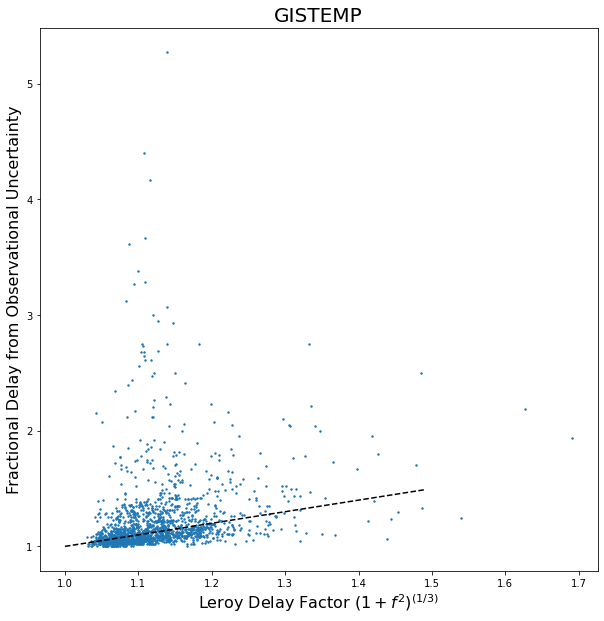

In [112]:
fig,ax = plt.subplots(1,1,figsize=(10,10))

ax.scatter(leroy_delay_factor_gistemp_stack,1+fractional_delay_gistemp_stack,s=2)

ax.plot(np.arange(1,1.5,0.01),np.arange(1,1.5,0.01),color='black',zorder=10,linestyle='dashed')

ax.set_xlabel('Leroy Delay Factor $(1+f^2)^{(1/3)}$',fontsize=16)
ax.set_ylabel('Fractional Delay from Observational Uncertainty',fontsize=16)

ax.set_title('GISTEMP',fontsize=20)

Text(0.5, 1.0, 'HadCRUT')

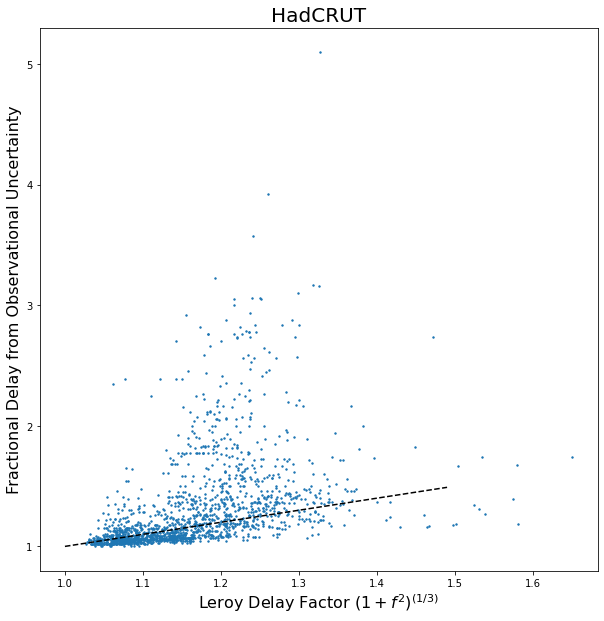

In [113]:
fig,ax = plt.subplots(1,1,figsize=(10,10))

ax.scatter(leroy_delay_factor_hadcrut_stack,1+fractional_delay_hadcrut_stack,s=2)

ax.plot(np.arange(1,1.5,0.01),np.arange(1,1.5,0.01),color='black',zorder=10,linestyle='dashed')

ax.set_xlabel('Leroy Delay Factor $(1+f^2)^{(1/3)}$',fontsize=16)
ax.set_ylabel('Fractional Delay from Observational Uncertainty',fontsize=16)

ax.set_title('HadCRUT',fontsize=20)

Why is this shift occuring? Probably has to do with the uncertainty over ocean surfaces between the two products.

In [114]:
fractional_delay_gistemp_error = (1 + fractional_delay_gistemp - leroy_delay_factor_gistemp)
fractional_delay_hadcrut_error = (1 + fractional_delay_hadcrut - leroy_delay_factor_hadcrut)

In [59]:
from matplotlib.colors import BoundaryNorm

In [66]:
sns.choose_diverging_palette()

interactive(children=(IntSlider(value=220, description='h_neg', max=359), IntSlider(value=10, description='h_p…

[(0.2519971417644415, 0.4987337088076726, 0.5751602783606602),
 (0.43026136111758173, 0.6200066482697917, 0.6787801878373952),
 (0.6085255804707219, 0.7412795877319109, 0.7824000973141302),
 (0.786789799823862, 0.86255252719403, 0.8860200067908652),
 (0.95, 0.95, 0.95),
 (0.954577257933482, 0.7665309859226215, 0.7803256889894359),
 (0.9197182699854205, 0.5873587656270927, 0.6117400023569117),
 (0.884859282037359, 0.40818654533156384, 0.4431543157243877),
 (0.8510408608937171, 0.23436274952246883, 0.2796010376480583)]

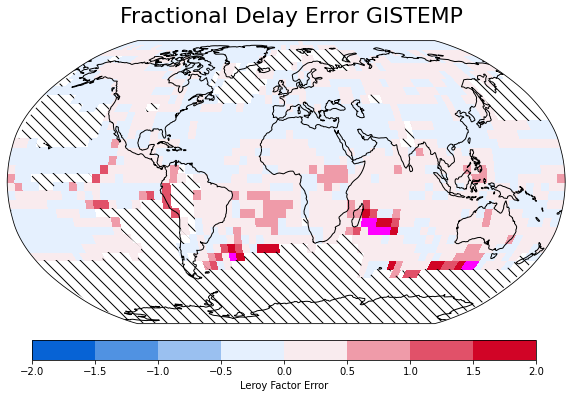

In [118]:
model_name = 'Fractional Delay Error GISTEMP'
data = fractional_delay_gistemp_error
mask = obs_mask_gistemp

delay_cmap = sns.light_palette('red',n_colors=10,reverse=False,as_cmap=True)
# delay_cmap2 = sns.light_palette('red',n_colors=10,reverse=False,as_cmap=False)
delay_cmap.set_over('magenta')
delay_cmap.set_under('lightblue')

# palette = sns.diverging_palette(257, 10, s=99, l=44, sep=50, n=8, as_cmap=True)
palette = sns.diverging_palette(257, 10, s=99, l=44, sep=35, n=8, as_cmap=True)
palette.set_over('magenta')
palette.set_under('purple')

levels = np.arange(-2,2.1,0.5)
norm = BoundaryNorm(levels, ncolors=delay_cmap.N, clip=True)
norm2 = BoundaryNorm(levels, ncolors=palette.N, clip=True)

fig = plt.figure(figsize=(10,7))

ax = plt.axes(projection=ccrs.Robinson(),)

cax = plt.axes([0.16, 0.15, 0.7, 0.04])

im = ax.pcolormesh(data.lon,data.lat,data,transform=ccrs.PlateCarree(),
                   vmin=-4,vmax=4,cmap=palette,norm=norm2)#,extend='max')

# grey = ax.contourf(obs_mask_gistemp.lon,obs_mask_gistemp.lat,~obs_mask_gistemp,
#                    transform=ccrs.PlateCarree(),
#                    extend='max',colors=['none','lightgray'],levels=[0,0.5,1.5],
#                   )

im2 = ax.contourf(mask.lon,mask.lat,~mask,colors='none',alpha=0,
                  levels=[-1,0.5,2],
                  transform=ccrs.PlateCarree(),hatches=[None,'\\\\'],extend='neither')

ax.coastlines()
ax.set_global()

fig.colorbar(im,orientation='horizontal',
             ticks=np.arange(-2,2.1,0.5),
             label='Leroy Factor Error',
             cax=cax
            )
fig.suptitle(model_name,fontsize=22,x=0.52,y=0.85)

plt.show()

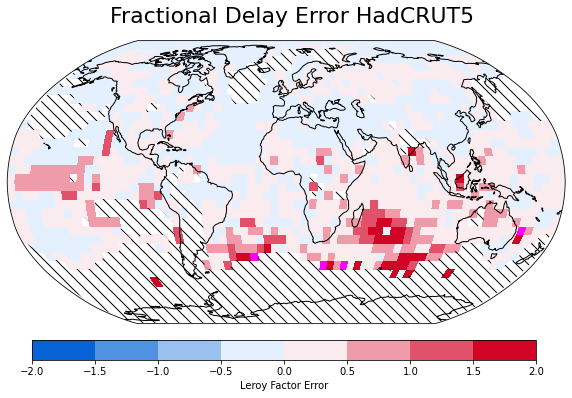

In [115]:
model_name = 'Fractional Delay Error HadCRUT5'
data = fractional_delay_hadcrut_error
mask = obs_mask_hadcrut
# data_undef = part_undef_hadcrut

delay_cmap = sns.light_palette('red',n_colors=10,reverse=False,as_cmap=True)
# delay_cmap2 = sns.light_palette('red',n_colors=10,reverse=False,as_cmap=False)
delay_cmap.set_over('magenta')
delay_cmap.set_under('lightblue')

# palette = sns.diverging_palette(257, 10, s=99, l=44, sep=50, n=8, as_cmap=True)
palette = sns.diverging_palette(257, 10, s=99, l=44, sep=35, n=8, as_cmap=True)
palette.set_over('magenta')
palette.set_under('purple')

levels = np.arange(-2,2.1,0.5)
norm = BoundaryNorm(levels, ncolors=delay_cmap.N, clip=True)
norm2 = BoundaryNorm(levels, ncolors=palette.N, clip=True)

fig = plt.figure(figsize=(10,7))

ax = plt.axes(projection=ccrs.Robinson(),)

cax = plt.axes([0.16, 0.15, 0.7, 0.04])

im = ax.pcolormesh(data.lon,data.lat,data,transform=ccrs.PlateCarree(),
                   vmin=-4,vmax=4,cmap=palette,norm=norm2)#,extend='max')

# grey = ax.contourf(obs_mask_hadcrut.lon,obs_mask_hadcrut.lat,~obs_mask_hadcrut,
#                    transform=ccrs.PlateCarree(),
#                    extend='max',colors=['none','lightgray'],levels=[0,0.5,1.5],
#                   )

im2 = ax.contourf(mask.lon,mask.lat,~mask,colors='none',alpha=0,
                  levels=[-1,0.5,2],
                  transform=ccrs.PlateCarree(),hatches=[None,'\\\\'],extend='neither')

ax.coastlines()
ax.set_global()

fig.colorbar(im,orientation='horizontal',
             ticks=np.arange(-2,2.1,0.5),
             label='Leroy Factor Error',
             cax=cax
            )
fig.suptitle(model_name,fontsize=22,x=0.52,y=0.85)

plt.show()

Despite the differences, this is pretty good agreement!

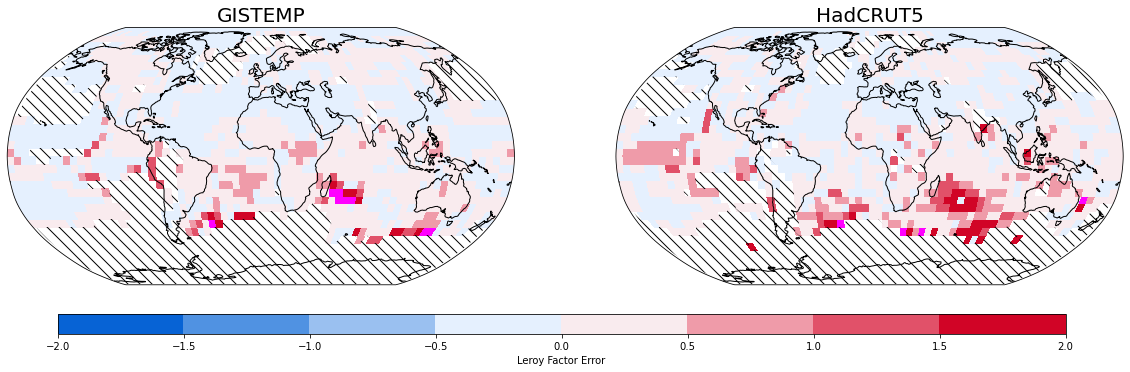

In [122]:
model_name = 'Fractional Delay Error GISTEMP'

delay_cmap = sns.light_palette('red',n_colors=10,reverse=False,as_cmap=True)
# delay_cmap2 = sns.light_palette('red',n_colors=10,reverse=False,as_cmap=False)
delay_cmap.set_over('magenta')
delay_cmap.set_under('lightblue')

# palette = sns.diverging_palette(257, 10, s=99, l=44, sep=50, n=8, as_cmap=True)
palette = sns.diverging_palette(257, 10, s=99, l=44, sep=35, n=8, as_cmap=True)
palette.set_over('magenta')
palette.set_under('purple')

levels = np.arange(-2,2.1,0.5)
norm = BoundaryNorm(levels, ncolors=delay_cmap.N, clip=True)
norm2 = BoundaryNorm(levels, ncolors=palette.N, clip=True)

fig,axs = sp_map(1,2,projection=ccrs.Robinson(),figsize=(20,7))
axs = axs.flat

cax = plt.axes([0.16, 0.15, 0.7, 0.04])

# Panel 1 - GISTEMP
data = fractional_delay_gistemp_error
mask = obs_mask_gistemp

im = axs[0].pcolormesh(data.lon,data.lat,data,transform=ccrs.PlateCarree(),
                      vmin=-4,vmax=4,cmap=palette,norm=norm2)#,extend='max')

# grey = ax.contourf(obs_mask_gistemp.lon,obs_mask_gistemp.lat,~obs_mask_gistemp,
#                    transform=ccrs.PlateCarree(),
#                    extend='max',colors=['none','lightgray'],levels=[0,0.5,1.5],
#                   )

im2 = axs[0].contourf(mask.lon,mask.lat,~mask,colors='none',alpha=0,
                     levels=[-1,0.5,2],
                     transform=ccrs.PlateCarree(),hatches=[None,'\\\\'],extend='neither')

axs[0].coastlines()
axs[0].set_global()
axs[0].set_title('GISTEMP',fontsize=20)

# Panel 2 - HadCRUT5
data = fractional_delay_hadcrut_error
mask = obs_mask_hadcrut

im = axs[1].pcolormesh(data.lon,data.lat,data,transform=ccrs.PlateCarree(),
                      vmin=-4,vmax=4,cmap=palette,norm=norm2)#,extend='max')

# grey = ax.contourf(obs_mask_gistemp.lon,obs_mask_gistemp.lat,~obs_mask_gistemp,
#                    transform=ccrs.PlateCarree(),
#                    extend='max',colors=['none','lightgray'],levels=[0,0.5,1.5],
#                   )

im2 = axs[1].contourf(mask.lon,mask.lat,~mask,colors='none',alpha=0,
                     levels=[-1,0.5,2],
                     transform=ccrs.PlateCarree(),hatches=[None,'\\\\'],extend='neither')

axs[1].coastlines()
axs[1].set_global()
axs[1].set_title('HadCRUT5',fontsize=20)

fig.colorbar(im,orientation='horizontal',
             ticks=np.arange(-2,2.1,0.5),
             label='Leroy Factor Error',
             cax=cax
            )

plt.show()

Text(0, 0.5, 'Fractional Delay from Observational Uncertainty')

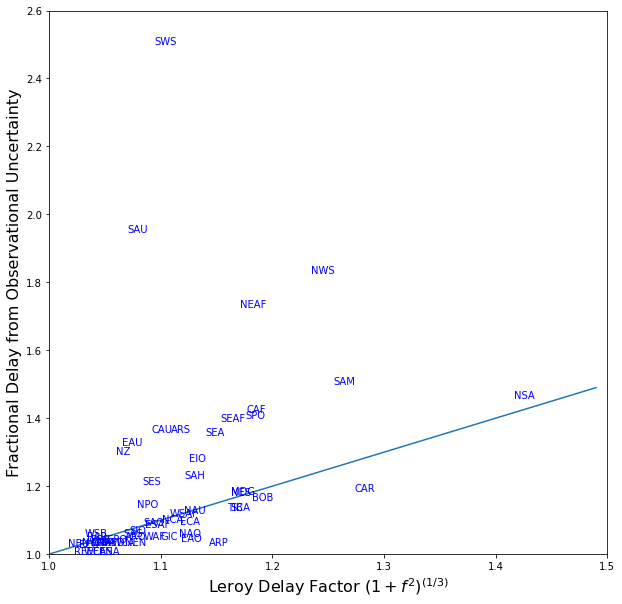

In [33]:
fig,ax = plt.subplots(1,1,figsize=(10,10))


for _x,_y in zip(leroy_delay_factor,1+fractional_delay):
    ax.text(_x,_y,str(_x.RegionAbbrev.values),color='blue')
# ax.scatter(leroy_delay_factor,fractional_delay,
           # marker=list(leroy_delay_factor.RegionAbbrev.values),
          # )

ax.plot(np.arange(1,1.5,0.01),np.arange(1,1.5,0.01))

ax.set_xlim(1,1.5)
ax.set_ylim(1,2.6)

ax.set_xlabel('Leroy Delay Factor $(1+f^2)^{(1/3)}$',fontsize=16)
ax.set_ylabel('Fractional Delay from Observational Uncertainty',fontsize=16)

In [179]:
baselist = []

for _year in gistemp_cesm1_unc_ratio.duration:
    
    _subset = gistemp_cesm1_unc_ratio.sel(duration=_year)
    
    baselist.append(_subset.where(_year+1960==mean_tte_gistemp))

In [183]:
baselist2 = xr.concat(baselist,dim='duration')

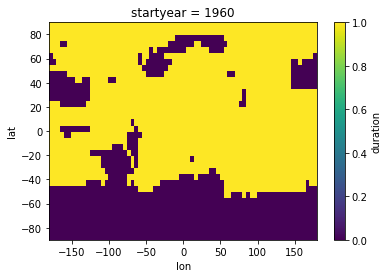

In [194]:
obs_mask_gistemp.plot()

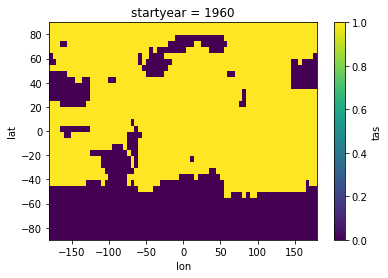

In [193]:
(~np.isnan(baselist2)).sum(dim='duration').plot()

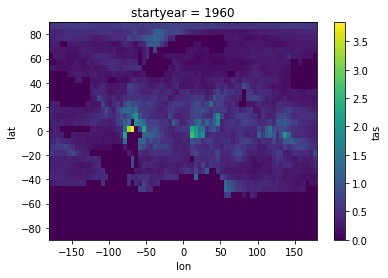

In [186]:
baselist2.sum(dim='duration').plot()

In [176]:
# Select the ratio at the year of emergence
ratios_at_emerge = []

for i_region in gistemp_cesm1_unc_ratio.RegionIndex:
    # print(i_region)    
    _year_of_emerge = mean_tte.sel(RegionIndex=i_region)
    # print(_year_of_emerge.values)
    # if not np.isnan(_year_of_emerge):
    _ratio_at_emerge = gistemp_cesm1_unc_ratio.sel(RegionIndex=i_region,duration=(_year_of_emerge-1960))
        # print(_ratio_at_emerge.values)

    _ratio = _ratio_at_emerge.drop('duration') # Drop this dimension so we can concatenate along something else
    ratios_at_emerge.append(_ratio)

ratios_at_emerge_ds = xr.concat(ratios_at_emerge,dim='RegionIndex')

AttributeError: 'DataArray' object has no attribute 'RegionIndex'

In [29]:
leroy_delay_factor = ((1 + ratios_at_emerge_ds)**(1/3)).compute()

__3. Use a simple regression to see how much of the variance is explained by the ratios of uncertainty.__

In [30]:
import scipy.stats as stats

In [92]:
import matplotlib as mpl
import matplotlib.cm as cm

In [31]:
leroy_linregress = stats.linregress(x=leroy_delay_factor,y=fractional_delay)

In [32]:
leroy_linregress

LinregressResult(slope=1.4577681706719505, intercept=-1.4097421408863313, rvalue=0.3883595183975226, pvalue=0.0037088523304936193, stderr=0.47968034072971755)

Text(0, 0.5, 'Fractional Delay from Observational Uncertainty')

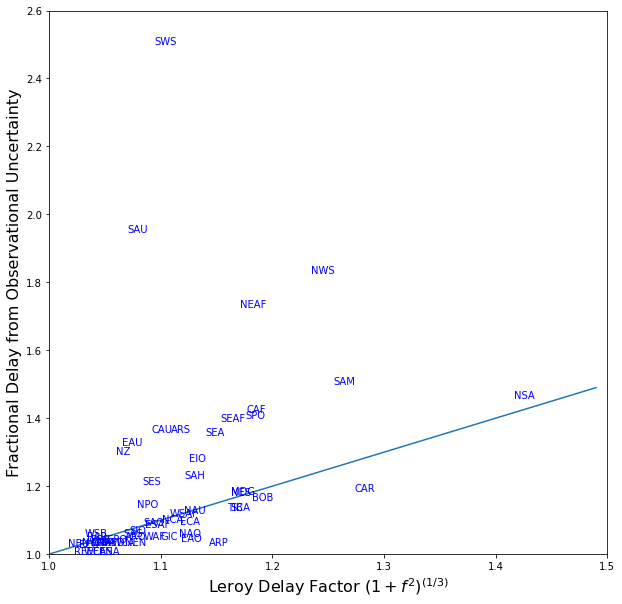

In [33]:
fig,ax = plt.subplots(1,1,figsize=(10,10))


for _x,_y in zip(leroy_delay_factor,1+fractional_delay):
    ax.text(_x,_y,str(_x.RegionAbbrev.values),color='blue')
# ax.scatter(leroy_delay_factor,fractional_delay,
           # marker=list(leroy_delay_factor.RegionAbbrev.values),
          # )

ax.plot(np.arange(1,1.5,0.01),np.arange(1,1.5,0.01))

ax.set_xlim(1,1.5)
ax.set_ylim(1,2.6)

ax.set_xlabel('Leroy Delay Factor $(1+f^2)^{(1/3)}$',fontsize=16)
ax.set_ylabel('Fractional Delay from Observational Uncertainty',fontsize=16)

Text(0, 0.5, 'Fractional Delay from Observational Uncertainty')

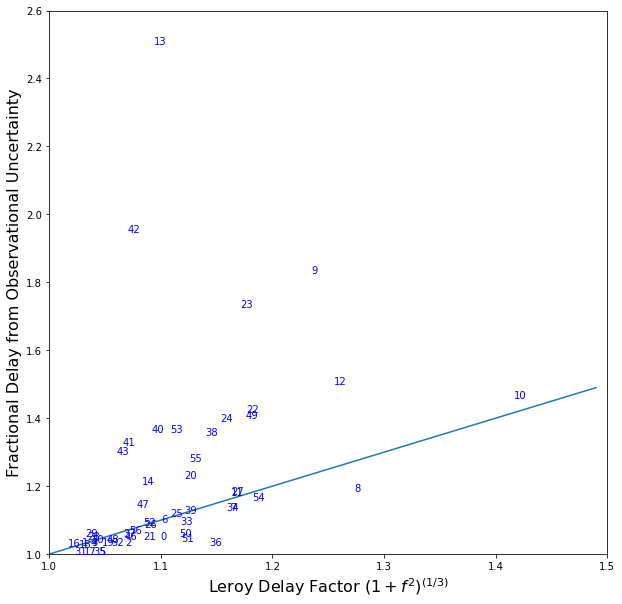

In [34]:
fig,ax = plt.subplots(1,1,figsize=(10,10))


for _x,_y in zip(leroy_delay_factor,1+fractional_delay):
    ax.text(_x,_y,str(_x.RegionIndex.values),color='blue')
# ax.scatter(leroy_delay_factor,fractional_delay,
           # marker=list(leroy_delay_factor.RegionAbbrev.values),
          # )

ax.plot(np.arange(1,1.5,0.01),np.arange(1,1.5,0.01))

ax.set_xlim(1,1.5)
ax.set_ylim(1,2.6)

ax.set_xlabel('Leroy Delay Factor $(1+f^2)^{(1/3)}$',fontsize=16)
ax.set_ylabel('Fractional Delay from Observational Uncertainty',fontsize=16)

__4. Exceptions should be due to departures from Leroy's assumptions: a. AR1 noise, no loss of stations, b. constant trend.__

__(a) scatter showing 1-1 line, maybe label the interesting crazy outliers__  

- maybe color points in some way based on findings of b and c   
    

__(b) Change in trend after TTE, somehow colored by position relative to 1-1 line__  

- red above 1-1, blue for below 1-1  

__(c) Ratio of sigma_var/sigma_obs after TTE, using same coloring as (b)__

#### Make figure iteratively.

__(a) scatter showing 1-1 line, maybe label the interesting crazy outliers__  

- maybe color points in some way based on findings of b and c   
    

Text(0, 0.5, 'Fractional Delay from Observational Uncertainty')

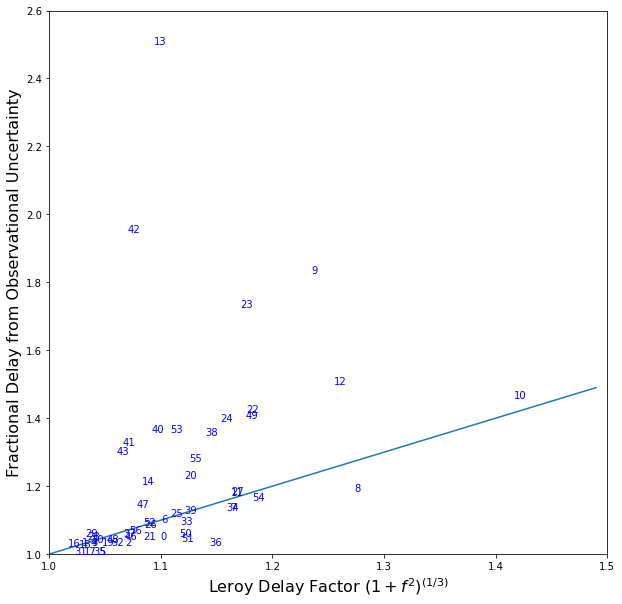

In [35]:
fig,ax = plt.subplots(1,1,figsize=(10,10))


for _x,_y in zip(leroy_delay_factor,1+fractional_delay):
    ax.text(_x,_y,str(_x.RegionIndex.values),color='blue')
# ax.scatter(leroy_delay_factor,fractional_delay,
           # marker=list(leroy_delay_factor.RegionAbbrev.values),
          # )

ax.plot(np.arange(1,1.5,0.01),np.arange(1,1.5,0.01))

ax.set_xlim(1,1.5)
ax.set_ylim(1,2.6)

ax.set_xlabel('Leroy Delay Factor $(1+f^2)^{(1/3)}$',fontsize=16)
ax.set_ylabel('Fractional Delay from Observational Uncertainty',fontsize=16)

__(b) Change in trend after TTE, somehow colored by position relative to 1-1 line__  

- red above 1-1, blue for below 1-1  

Is the delay greater than estimated from Leroy?

In [73]:
delay_yrs = (true_tte[obs_mask] - mean_tte[obs_mask]).compute()

In [169]:
delay_yrs

<xarray.DataArray 'duration' (RegionIndex: 54)>
array([ 2.,  1.,  1.,  1.,  1.,  0.,  3.,  4.,  7., 19., 16.,  4., 17.,
       33.,  7.,  1.,  0.,  1.,  1.,  6.,  1., 10., 16.,  9.,  3.,  2.,
        3.,  2.,  2.,  1.,  0.,  1.,  3.,  5.,  0.,  1.,  2.,  7.,  3.,
       10.,  9., 18., 12.,  2.,  6.,  1.,  8.,  2.,  1.,  1., 10.,  3.,
        6.,  1.])
Coordinates:
    startyear     int64 1960
  * RegionIndex   (RegionIndex) int64 0 1 2 3 4 5 6 7 ... 50 51 52 53 54 55 56
    RegionName    (RegionIndex) object 'Greenland/Iceland' ... 'S.Indic-Ocean'
    RegionAbbrev  (RegionIndex) object 'GIC' 'NWN' 'NEN' ... 'BOB' 'EIO' 'SIO'

In [171]:
delay_yrs[-13]

<xarray.DataArray 'duration' ()>
array(18.)
Coordinates:
    startyear     int64 1960
    RegionIndex   int64 42
    RegionName    object 'S.Australia'
    RegionAbbrev  object 'SAU'

In [172]:
delay_yrs.RegionName[-13]

<xarray.DataArray 'RegionName' ()>
array('S.Australia', dtype=object)
Coordinates:
    startyear     int64 1960
    RegionIndex   int64 42
    RegionName    object 'S.Australia'
    RegionAbbrev  object 'SAU'

In [36]:
fractional_delay_residual = 1 + fractional_delay - leroy_delay_factor

In [76]:
# Select the trend timeseries starting at the year of emergence
trends_from_emerge = []

for i_region in gistemp_2x2_trends_50perc.RegionIndex:
    # print(i_region)
    
    # if (true_tte.sel(RegionIndex=i_region) != np.nan):
    if (~np.isnan(true_tte.sel(RegionIndex=i_region))):
        _year_of_emerge  = mean_tte.sel(RegionIndex=i_region)
        _delay           = delay_yrs.sel(RegionIndex=i_region)
        _emerge_duration = _year_of_emerge - 1960
        # Old code take all years after emerge
        # _trends_from_emerge = gistemp_2x2_tren÷ds_50perc.sel(RegionIndex=i_region,).sel(duration=slice(_year_of_emerge-1960,None))
        
        # New code take years between mean emerge and true emerge
        _trends_from_emerge = gistemp_2x2_trends_50perc.sel(RegionIndex=i_region,).sel(duration=slice(_emerge_duration,_emerge_duration+_delay))

        # _ratio = _ratio_at_emerge.drop('duration') # Drop this dimension so we can concatenate along something else
        trends_from_emerge.append(_trends_from_emerge.compute())

# ratios_at_emerge_ds = xr.concat(ratios_at_emerge,dim='RegionIndex')

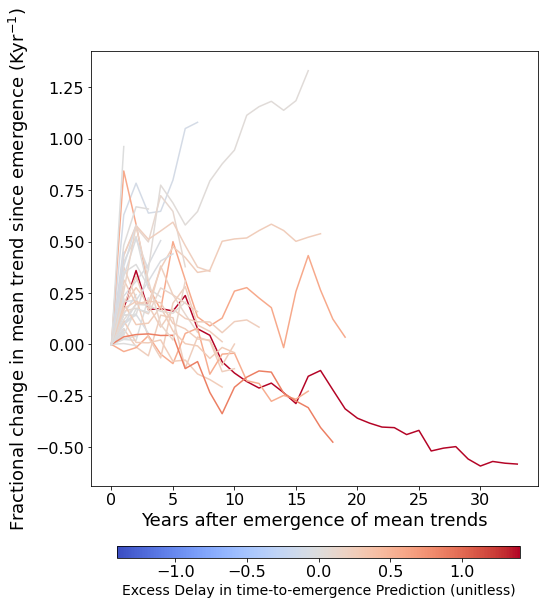

In [153]:
fig,ax = plt.subplots(1,1,figsize=(8,8))

min_val, max_val = -1*max(fractional_delay_residual), max(fractional_delay_residual)

# use the coolwarm colormap that is built-in, and goes from blue to red
cmap = mpl.cm.coolwarm
norm = mpl.colors.Normalize(vmin=min_val, vmax=max_val)

# convert your distances to color coordinates, first applying the norm and then querying the cmap
color_list = cmap(norm(fractional_delay_residual))

for _trend_tseries,_delay_resid,_color in zip(trends_from_emerge,
                                              fractional_delay_residual,
                                              color_list):
    
    if len(_trend_tseries) > 0:
        # ax.plot(_trend_tseries-_trend_tseries[0],color=color)
        ax.plot((_trend_tseries-_trend_tseries[0])/_trend_tseries[0],color=_color)
        
# ax.set_ylabel('Change in mean trend since emergence (Kyr$^{-1}$)',fontsize=18)
ax.set_ylabel('Fractional change in mean trend since emergence (Kyr$^{-1}$)',fontsize=18)
ax.set_xlabel('Years after emergence of mean trends',fontsize=18)
ax.tick_params(axis='both',labelsize=16)

cbar_axh = fig.add_axes([0.17, 0.0, 0.70, 0.02])

cb = mpl.colorbar.ColorbarBase(ax=cbar_axh, 
                               cmap=cmap, 
                               norm=norm, 
                               # ticks = sorted(distance_list), 
                               orientation='horizontal')

cb.set_label('Excess Delay in time-to-emergence Prediction (unitless)',fontsize=14)
cbar_axh.tick_params(axis='x',labelsize=16 )#rotation=90)

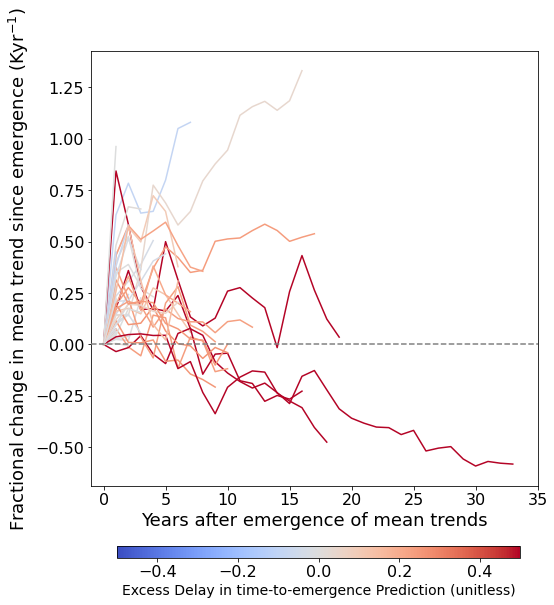

In [161]:
fig,ax = plt.subplots(1,1,figsize=(8,8))

# min_val, max_val = -1*max(fractional_delay_residual), max(fractional_delay_residual)
min_val, max_val = -0.5, 0.5

# use the coolwarm colormap that is built-in, and goes from blue to red
cmap = mpl.cm.coolwarm
norm = mpl.colors.Normalize(vmin=min_val, vmax=max_val)

# convert your distances to color coordinates, first applying the norm and then querying the cmap
color_list = cmap(norm(fractional_delay_residual))

for _trend_tseries,_delay_resid,_color in zip(trends_from_emerge,
                                              fractional_delay_residual,
                                              color_list):
    
    if len(_trend_tseries) > 0:
        # ax.plot(_trend_tseries-_trend_tseries[0],color=color)
        ax.plot((_trend_tseries-_trend_tseries[0])/_trend_tseries[0],color=_color)

ax.hlines(y=0,xmin=-1,xmax=35,color='grey',zorder=100,linestyle='dashed')
        
# ax.set_ylabel('Change in mean trend since emergence (Kyr$^{-1}$)',fontsize=18)
ax.set_ylabel('Fractional change in mean trend since emergence (Kyr$^{-1}$)',fontsize=18)
ax.set_xlabel('Years after emergence of mean trends',fontsize=18)
ax.set_xlim(-1,35)
ax.tick_params(axis='both',labelsize=16)

cbar_axh = fig.add_axes([0.17, 0.0, 0.70, 0.02])

cb = mpl.colorbar.ColorbarBase(ax=cbar_axh, 
                               cmap=cmap, 
                               norm=norm, 
                               # ticks = sorted(distance_list), 
                               orientation='horizontal')

cb.set_label('Excess Delay in time-to-emergence Prediction (unitless)',fontsize=14)
cbar_axh.tick_params(axis='x',labelsize=16 )#rotation=90)

Red when the trend emergence is delayed more than expected. Blue when the trend emergence is delayed less than expected.

Not super clear here. But in general the trends that are delayed by less than expected seem to show increasing trends after the emergence of the mean trend (i.e. faster warming). This makes sense, but the picture is far from clear.

__(c) Ratio of sigma_var/sigma_obs after TTE, using same coloring as (b)__

In [80]:
# Select the trend timeseries starting at the year of emergence
ratios_from_emerge = []

for i_region in gistemp_cesm1_unc_ratio.RegionIndex:
    # print(i_region)    
    _year_of_emerge  = mean_tte.sel(RegionIndex=i_region)
    _delay           = delay_yrs.sel(RegionIndex=i_region)
    _emerge_duration = _year_of_emerge - 1960    

    _ratio_from_emerge = gistemp_cesm1_unc_ratio.sel(RegionIndex=i_region,).sel(duration=slice(_emerge_duration,_emerge_duration+_delay))
        # print(_ratio_at_emerge.values)

    # _ratio = _ratio_at_emerge.drop('duration') # Drop this dimension so we can concatenate along something else
    ratios_from_emerge.append(_ratio_from_emerge.compute())

# ratios_at_emerge_ds = xr.concat(ratios_at_emerge,dim='RegionIndex')

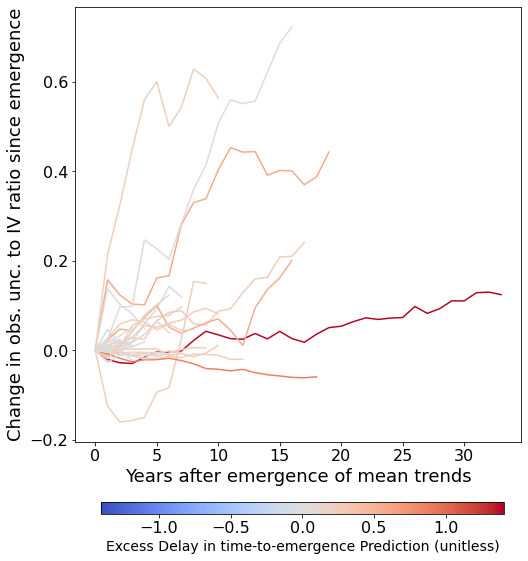

In [143]:
fig,ax = plt.subplots(1,1,figsize=(8,8))

min_val, max_val = -1*max(fractional_delay_residual), max(fractional_delay_residual)

# use the coolwarm colormap that is built-in, and goes from blue to red
cmap = mpl.cm.coolwarm
norm = mpl.colors.Normalize(vmin=min_val, vmax=max_val)

# convert your distances to color coordinates, first applying the norm and then querying the cmap
color_list = cmap(norm(fractional_delay_residual))

for _ratio_tseries,_delay_resid,_color in zip(ratios_from_emerge,
                                              fractional_delay_residual,
                                              color_list):
    
    if len(_trend_tseries) > 0:
        ax.plot(_ratio_tseries-_ratio_tseries[0],color=_color)
        
ax.set_ylabel('Change in obs. unc. to IV ratio since emergence',fontsize=18)
ax.set_xlabel('Years after emergence of mean trends',fontsize=18)
ax.tick_params(axis='both',labelsize=16)

cbar_axh = fig.add_axes([0.17, 0.0, 0.70, 0.02])
# cbar1 = fig.colorbar(im, cax=cbar_axh,orientation='horizontal')

# cb = mpl.colorbar.ColorbarBase(ax=cbar_axh, 
cb = mpl.colorbar.ColorbarBase(ax=cbar_axh, 
                               cmap=cmap, 
                               norm=norm, 
                               # ticks = sorted(distance_list), 
                               orientation='horizontal')

cb.set_label('Excess Delay in time-to-emergence Prediction (unitless)',fontsize=14)
cbar_axh.tick_params(axis='x',labelsize=16 )#rotation=90)

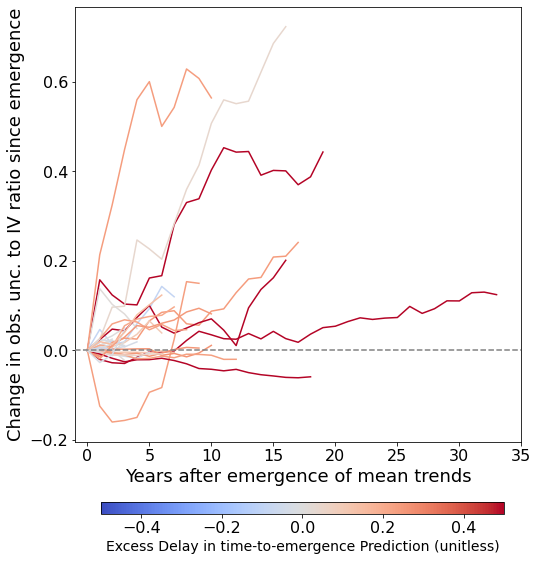

In [162]:
fig,ax = plt.subplots(1,1,figsize=(8,8))

# min_val, max_val = -1*max(fractional_delay_residual), max(fractional_delay_residual)
min_val, max_val = -0.5, 0.5

# use the coolwarm colormap that is built-in, and goes from blue to red
cmap = mpl.cm.coolwarm
norm = mpl.colors.Normalize(vmin=min_val, vmax=max_val)

# convert your distances to color coordinates, first applying the norm and then querying the cmap
color_list = cmap(norm(fractional_delay_residual))

for _ratio_tseries,_delay_resid,_color in zip(ratios_from_emerge,
                                              fractional_delay_residual,
                                              color_list):
    
    if len(_trend_tseries) > 0:
        ax.plot(_ratio_tseries-_ratio_tseries[0],color=_color)
        
ax.hlines(y=0,xmin=-1,xmax=35,color='grey',zorder=100,linestyle='dashed')

ax.set_ylabel('Change in obs. unc. to IV ratio since emergence',fontsize=18)
ax.set_xlabel('Years after emergence of mean trends',fontsize=18)
ax.set_xlim(-1,35)
ax.tick_params(axis='both',labelsize=16)

cbar_axh = fig.add_axes([0.17, 0.0, 0.70, 0.02])

cb = mpl.colorbar.ColorbarBase(ax=cbar_axh, 
                               cmap=cmap, 
                               norm=norm, 
                               # ticks = sorted(distance_list), 
                               orientation='horizontal')

cb.set_label('Excess Delay in time-to-emergence Prediction (unitless)',fontsize=14)
cbar_axh.tick_params(axis='x',labelsize=16 )#rotation=90)

Again, this is kind of unclear unfortunately. But in general, when the uncertainty ratio increases a lot after the mean emergence, the true delay generally exceeds the expected delay, which makes sense. We see that the uncertainty ratio often stays very similar, but it rarely decreases. 

#### Combine both metrics

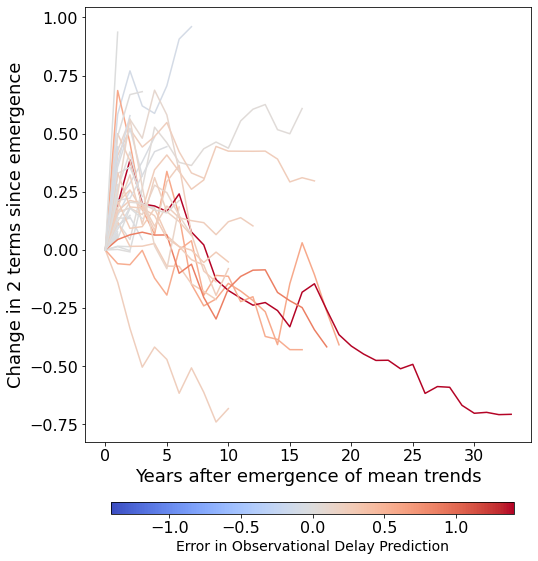

In [150]:
# Make symmetric
# min_val, max_val = min(fractional_delay_residual), max(fractional_delay_residual)
min_val, max_val = -1*max(fractional_delay_residual), max(fractional_delay_residual)

# use the coolwarm colormap that is built-in, and goes from blue to red
cmap = mpl.cm.coolwarm
norm = mpl.colors.Normalize(vmin=min_val, vmax=max_val)

# convert your distances to color coordinates, first applying the norm and then querying the cmap
color_list = cmap(norm(fractional_delay_residual))

fig,ax = plt.subplots(1,1,figsize=(8,8))

for _ratio_tseries,_trend_tseries,_delay_resid,_color in zip(ratios_from_emerge,
                                                             trends_from_emerge,
                                                             fractional_delay_residual,
                                                             color_list):
    
    if len(_trend_tseries) > 0:
        
        _ratio_term = _ratio_tseries - _ratio_tseries[0]
        _trend_term = (_trend_tseries - _trend_tseries[0]) / _trend_tseries[0]
        ax.plot(_trend_term - _ratio_term, color=_color)      
        
ax.set_ylabel('Change in 2 terms since emergence',fontsize=18)
ax.set_xlabel('Years after emergence of mean trends',fontsize=18)
ax.tick_params(axis='both',labelsize=16)

cbar_axh = fig.add_axes([0.17, 0.0, 0.70, 0.02])
# cbar1 = fig.colorbar(im, cax=cbar_axh,orientation='horizontal')

# cb = mpl.colorbar.ColorbarBase(ax=cbar_axh, 
cb = mpl.colorbar.ColorbarBase(ax=cbar_axh, 
                               cmap=cmap, 
                               norm=norm, 
                               # boundaries=[-0.2,1.4],
                               # ticks = np.arange(-0.2,1.5,0.2), 
                               orientation='horizontal')

cb.set_label('Error in Observational Delay Prediction',fontsize=14)
cbar_axh.tick_params(axis='x',labelsize=16 )#rotation=90)

# cb = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, ticks = sorted(distance_list), orientation='horizontal')
# cb.set_label('Distance (least to greatest)')
# ax.tick_params(axis='x', rotation=90)

## Old Code

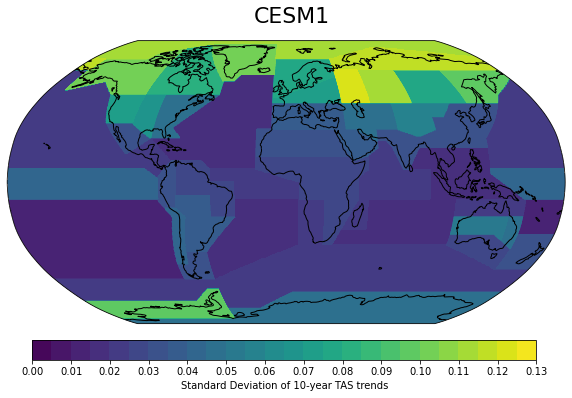

In [48]:
model_name = 'CESM1'
_unc_mask = cesm1_unc_mask

fig = plt.figure(figsize=(10,7))

ax = plt.axes(projection=ccrs.Robinson(),)

cax = plt.axes([0.16, 0.15, 0.7, 0.04])

im = ax.contourf(_unc_mask.lon,_unc_mask.lat,_unc_mask, 60,
             transform=ccrs.PlateCarree(),levels=np.linspace(0,0.13,27))

ax.coastlines()
ax.set_global()

fig.colorbar(im,orientation='horizontal',
             ticks=np.linspace(0,0.13,14),
             label='Standard Deviation of 10-year TAS trends',
             cax=cax
            )
fig.suptitle(model_name,fontsize=22,x=0.52,y=0.85)

plt.show()

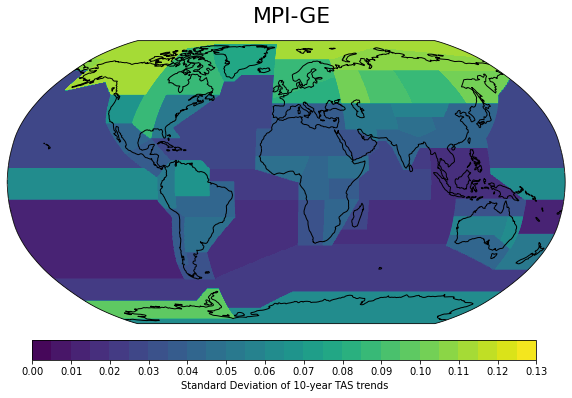

In [97]:
model_name = 'MPI-GE'
_unc_mask = mpi_unc_mask

fig = plt.figure(figsize=(10,7))

ax = plt.axes(projection=ccrs.Robinson(),)

cax = plt.axes([0.16, 0.15, 0.7, 0.04])

im = ax.contourf(_unc_mask.lon,_unc_mask.lat,_unc_mask, 60,
             transform=ccrs.PlateCarree(),levels=np.linspace(0,0.13,27))

ax.coastlines()
ax.set_global()

fig.colorbar(im,orientation='horizontal',
             ticks=np.linspace(0,0.13,14),
             label='Standard Deviation of 10-year TAS trends',
             cax=cax
            )
fig.suptitle(model_name,fontsize=22,x=0.52,y=0.85)

plt.show()

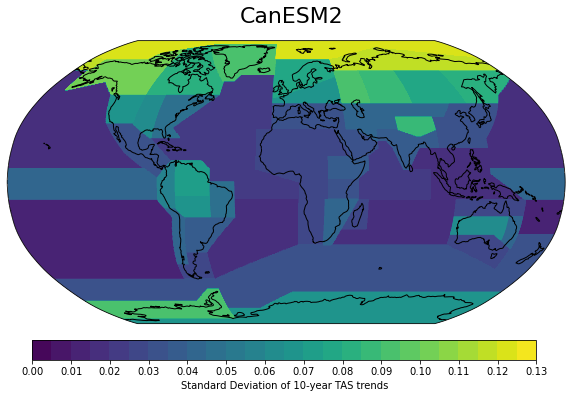

In [98]:
model_name = 'CanESM2'
_unc_mask = canesm2_unc_mask

fig = plt.figure(figsize=(10,7))

ax = plt.axes(projection=ccrs.Robinson(),)

cax = plt.axes([0.16, 0.15, 0.7, 0.04])

im = ax.contourf(_unc_mask.lon,_unc_mask.lat,_unc_mask, 60,
             transform=ccrs.PlateCarree(),levels=np.linspace(0,0.13,27))

ax.coastlines()
ax.set_global()

fig.colorbar(im,orientation='horizontal',
             ticks=np.linspace(0,0.13,14),
             label='Standard Deviation of 10-year TAS trends',
             cax=cax
            )
fig.suptitle(model_name,fontsize=22,x=0.52,y=0.85)

plt.show()

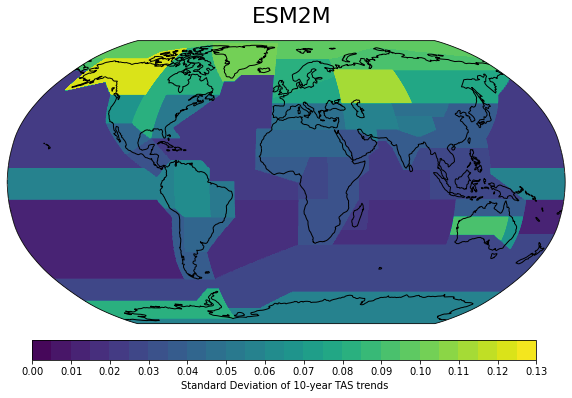

In [99]:
model_name = 'ESM2M'
_unc_mask = esm2m_unc_mask

fig = plt.figure(figsize=(10,7))

ax = plt.axes(projection=ccrs.Robinson(),)

cax = plt.axes([0.16, 0.15, 0.7, 0.04])

im = ax.contourf(_unc_mask.lon,_unc_mask.lat,_unc_mask, 60,
             transform=ccrs.PlateCarree(),levels=np.linspace(0,0.13,27))

ax.coastlines()
ax.set_global()

fig.colorbar(im,orientation='horizontal',
             ticks=np.linspace(0,0.13,14),
             label='Standard Deviation of 10-year TAS trends',
             cax=cax
            )
fig.suptitle(model_name,fontsize=22,x=0.52,y=0.85)

plt.show()